<a href="https://colab.research.google.com/github/Alexher90/An-lisis-de-Datos-2/blob/master/Soluci%C3%B3n_Semana8_RedNeuronalRecurrente_LSTMBidireccional_Actividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

**Presentado por: Alexander Hernández Páez (200920588), Alexander Camargo (200911325), Juan David Cortés (201728568), Wilson Felipe González (200924943)**

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 


También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [2]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [3]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step
25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [4]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [5]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

1646592/1641221 [==============================] - 0s 0us/step


Veamos el primer comentario de entrenamiento que es positivo:

In [6]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [7]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [8]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 224s 572ms/step - loss: 0.4384 - accuracy: 0.7929 - val_loss: 0.3446 - val_accuracy: 0.8516
Epoch 2/3
391/391 [==============================] - 232s 593ms/step - loss: 0.2121 - accuracy: 0.9206 - val_loss: 0.4045 - val_accuracy: 0.8272
Epoch 3/3
391/391 [==============================] - 224s 572ms/step - loss: 0.1357 - accuracy: 0.9519 - val_loss: 0.4200 - val_accuracy: 0.8446
Desempeño (exactitud): accu_v1=0.8445600271224976 , accu_v2=0.8376399874687195
Epoch 1/3
391/391 [==============================] - 220s 562ms/step - loss: 0.2342 - accuracy: 0.9148 - val_loss: 0.2217 - val_accuracy: 0.9162
Epoch 2/3
391/391 [==============================] - 219s 559ms/step - loss: 0.1305 - accuracy: 0.9530 - val_loss: 0.3215 - val_accuracy: 0.9074
Epoch 3/3
391/391 [==============================] - 219s 560ms/step - loss: 0.0728 - accuracy: 0.9778 - val_loss: 0.3265 - val_accuracy: 0.9073
Desempeño (exactitud): accu_v1=0.9072800278663635 ,

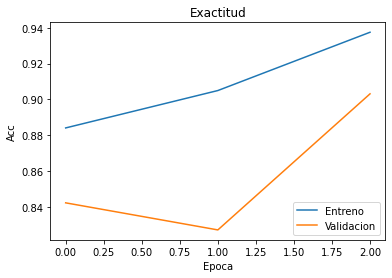

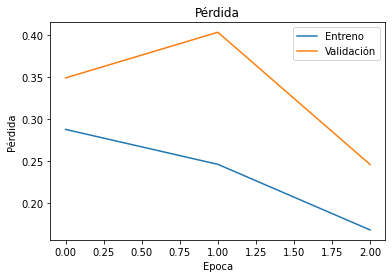

In [10]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [11]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [14]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11114  1386]
 [  819 11681]]
Exactitud:  0.9118000268936157


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [15]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10050  2450]
 [ 1609 10891]]
Exactitud:  0.8376399874687195


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

**Para este ejercicio, usamos una red recurrente GRU uni-direccional con activación Tangente Hiperbólica.**

**Según el resultado obtenido en la prueba, este modelo nos genera un accuracy de un punto porcentual por encima con respecto al modelo LSTM bidireccional. Adicionalemnte, incrementamos el rango de iteraciones en la validación cruzada y el parámetro beta_2 del optimizador lo redujimos de 0.99 a 0.8.**

**El resultado del modelo mejoró notablemente el accuracy del anterior modelo y mantuvo la función de pérdida en un nivel significativamente bajo.**

In [21]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
z = layers.Embedding(max_features, 128)(inputs)

# Añadimos 1 unidad GRU con activación Tangente Hiperbólica:
z = layers.GRU(64, activation = "tanh", return_sequences=False)(z)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(z)

# Guardamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 2,597,313
Trainable params: 2,597,313
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Inicializamos la tabla donde guardamos los resultados
z = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.8)

# Inicializamos el error 
err_p = 999

for i in range(0,4,1):
    r = i^4
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    z.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(z)

Epoch 1/3
391/391 [==============================] - 64s 163ms/step - loss: 0.0135 - accuracy: 0.9967 - val_loss: 0.0700 - val_accuracy: 0.9814
Epoch 2/3
391/391 [==============================] - 64s 164ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0889 - val_accuracy: 0.9777
Epoch 3/3
391/391 [==============================] - 64s 164ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.2412 - val_accuracy: 0.9466
Desempeño (exactitud): accu_v1=0.9466400146484375 , accu_v2=0.8102399706840515
Epoch 1/3
391/391 [==============================] - 65s 166ms/step - loss: 0.0490 - accuracy: 0.9854 - val_loss: 0.0413 - val_accuracy: 0.9872
Epoch 2/3
391/391 [==============================] - 65s 166ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0611 - val_accuracy: 0.9844
Epoch 3/3
391/391 [==============================] - 65s 167ms/step - loss: 0.0039 - accuracy: 0.9984 - val_loss: 0.0699 - val_accuracy: 0.9833
Desempeño (exactitud): accu_v1=0.9832800030708313 , accu_

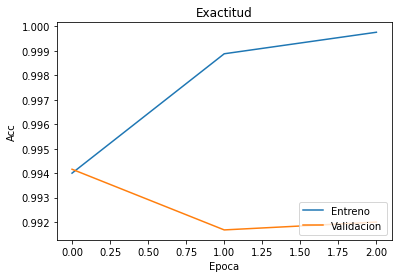

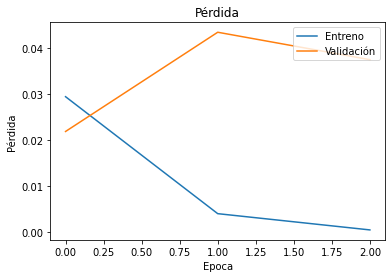

In [29]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

**Para este ejercicio, usamos una red recurrente GRU bidireccional con activación sigmoide. El beta_2 lo disminuimos de 0.99 a 0.8 y adicionamos un rango de iteraciones.**

**Podemos ver adicionalmente que este modelo, en las primeras 3 iteraciones, tiene un resultado levemente mejor que el modelo GRU unidireccional, por lo que podemos concluir que este modelo es el que mejor desempeño de accuracy obtuvo, a pesar que el anterior modelo tuvo un mejor rendimiento en la función de pérdida. Por otro lado, pudimos evidenciar que la red recurrente GRU tuvo resultados levemente mejores que el LSTM, tanto para la ocación en que se usó de manera unidireccional como también bidireccional.**

**Con el fin de mejorar el desempeño de la red, se recomienda mantener 3 iteraciones por ejercicio y disminuir el beta_2. Adicionalmente, se debería experimentar los ejercicios tanto para la activación sigmoide como activación de tangente hiperbólica, a pesar que no se puede concluir que alguna de estas dos activaciones sea mejor que la otra.**

In [34]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades GRU bidireccionales
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         74496     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 129       
Total params: 2,709,121
Trainable params: 2,709,121
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.8)

# Inicializamos el error 
err_p = 999

for i in range(0,4,1):
    r = i^4
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 208s 532ms/step - loss: 0.4706 - accuracy: 0.7593 - val_loss: 0.3701 - val_accuracy: 0.8438
Epoch 2/3
391/391 [==============================] - 207s 530ms/step - loss: 0.2149 - accuracy: 0.9157 - val_loss: 0.3676 - val_accuracy: 0.8622
Epoch 3/3
391/391 [==============================] - 208s 533ms/step - loss: 0.1187 - accuracy: 0.9581 - val_loss: 0.4411 - val_accuracy: 0.8307
Desempeño (exactitud): accu_v1=0.8307200074195862 , accu_v2=0.8203999996185303
Epoch 1/3
391/391 [==============================] - 210s 538ms/step - loss: 0.2097 - accuracy: 0.9212 - val_loss: 0.1834 - val_accuracy: 0.9346
Epoch 2/3
391/391 [==============================] - 206s 527ms/step - loss: 0.0919 - accuracy: 0.9688 - val_loss: 0.2843 - val_accuracy: 0.8966
Epoch 3/3
391/391 [==============================] - 208s 533ms/step - loss: 0.0377 - accuracy: 0.9874 - val_loss: 0.3208 - val_accuracy: 0.9109
Desempeño (exactitud): accu_v1=0.9108800292015076 ,

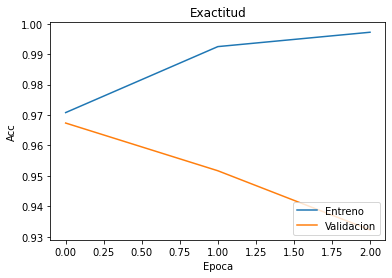

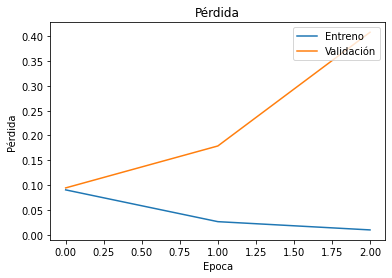

In [36]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()